# Model NEATM 余亮亮 修改 $\alpha, \phi$

$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$

$p_v=\frac{A_B}{q}  ,q_s=\frac{F_{sun}}{d^2}$

$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$

$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$

$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


### test Fortran

In [16]:
import os
d = 1.12554
delta = 1.14078
alpha = 0
D = 40.0
lamda = 12.0
eta = 1.23
A = 0.0505
para = str(d)+' '+str(delta)+' '+str(alpha)+' '+str(D)+' '+str(lamda)+' '+str(eta)+' '+str(A)
exe ='./a.out '+' '+para 
ret = os.system(exe)
f = os.popen(exe)
print("hello=",f.readline())
f.close()
#print('./a.out '+' '+para)


hello= 


sh: 1: ./a.out: not found
/bin/sh: 1: ./a.out: not found


32512

# MCMC_NEATM

## define const & import

In [17]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5  
Fsun = 1.3608e3# sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007004E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 21.4
G = 0.15
Ndd = 15
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

## old hhq

In [18]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            #print(f"Tss = {T-273}\n")
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    #print('hhq',delta)
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))

    F = F*(lamda)**2/cl*1e29
    #print('hhq2',delta)
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

In [19]:
#testn = 1
#for i in range(testn):
  #  print(neatm_hhq(10000,1.5,100,0.102482,1.02233,1.411,0.00012,0.19))

In [20]:
#for i in range(5):
   # print(15+i*100)
   # print(neatm_hhq(15+i*100,1.5,100,0.102482,1.02233,1.411,0.00012,0.19))

## jhx

In [21]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,pi/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## cython

In [22]:
import cython
#ret = os.popen('./a.out 2 6')
#a1 = ret.readlines()
import subprocess
#ret save "return"  not "print"
def neatm_phhq( Ndd, eta,D,delta,dd,alpha,lamda,A): 
    exeStr = './a.out '+str(eta)+' '+str(D)+' '+str(delta)+' '+str(dd)+' '+str(alpha)+' '+str(lamda)+' '+str(A)+' '+str(Ndd)
    f = os.popen(exeStr)
    out = f.readlines()
    f.close()
    out = np.float64(out)
    return out
def Model_neatm_phhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    lamda1 = lamda1*1e-6
    lamda2 = lamda2*1e-6
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_phhq( Ndd, eta,D,delta[i],d[i],alpha[i],lamda1,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_phhq( Ndd, eta,D,delta[i],d[i],alpha[i],lamda2,A)
    return flux



## read data file

处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [23]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = namelist[4].lower()
name = '2010jn71'
name

'2010jn71'

计算delta d 看看对不对

In [24]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
#print(obsec)
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
alpha_N/pi*180

[0.10626916 0.10532268 0.10437609 0.10390322 0.10342941 0.10248265
 0.10200971 0.10106286 0.16815758 0.16907279 0.16952969 0.17135731
 0.17181333 0.17363738 0.10626916 0.10532268 0.10437609 0.10390322
 0.10342941 0.10248265 0.10200971 0.10106286 0.16815758 0.16907279
 0.16952969 0.17135731 0.17181333 0.17363738]


array([80.09450103, 80.28108659, 80.46908073, 80.56352448, 80.65851707,
       80.84943477, 80.94536824, 81.13858114, 80.73849343, 80.59860584,
       80.52886814, 80.25055746, 80.1812716 , 79.90474298, 80.09450103,
       80.28108659, 80.46908073, 80.56352448, 80.65851707, 80.84943477,
       80.94536824, 81.13858114, 80.73849343, 80.59860584, 80.52886814,
       80.25055746, 80.1812716 , 79.90474298])

In [25]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat = np.loadtxt(f'w34_{name}.txt')

#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)

#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)

#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)

#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
print(neatm_jhx(Ndd,dd_N[0],delta_N[0],alpha_N[0],100,12,1.5,0.19))
print(neatm_ohhq(Ndd,1.5,100,delta_N[0],dd_N[0],alpha_N[0],12*1e-6,0.19))


[17.230942581479635]
17.376166238081087


/tmp/ipykernel_3492/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


/tmp/ipykernel_3492/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
No handles with labels found to put in legend.
/tmp/ipykernel_3492/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy



jhx: [14.11758423 14.33172287 14.55058851 14.66172605 14.774312   15.00303345
 15.11919978 15.35568508  5.50596175  5.45657893  5.43215475  5.33595366
  5.31231676  5.21919852 29.32024089 29.76264657 30.21504579 30.44485735
 30.67772469 31.15098964 31.39145518 31.8811846  11.49853499 11.39759891
 11.34769455 11.15124582 11.10300534 10.91306679]

ohhq: [13.7749889  13.96995681 14.16916367 14.27029485 14.37272835 14.58077838
 14.68642308 14.9014446   5.35285285  5.30869097  5.28685112  5.20084157
  5.17971157  0.         30.33667966 30.77521947 31.22370461 31.45154497
 31.6824277  32.15170238 32.39016433 32.87586753 11.86912737 11.77014138
 11.7212152  11.52870626 11.48145478 11.29549145]


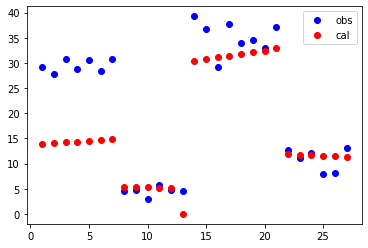

In [26]:
y = obsdat
nt = np.arange(len(d_N))
theta = [6.9,204]
flux1 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
#plt.plot(nt,flux,label = 'hhq')
print('\njhx:',Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai))
print('\nohhq:',Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai))
##
#plt.subplot(1,2,1)
#plt.plot(nt[1:60],obsdat[1:60],'bo',label = 'obs')
#plt.plot(nt[1:60],flux1[1:60],'ro',label = 'cal')
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()
##
#plt.subplot(1,2,2)
plt.plot(nt[1:60],obsdat[1:60],'bo',label = 'obs')
plt.plot(nt[1:60],flux2[1:60],'ro',label = 'cal')
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()

lenthi = [8,30,200]
dddd = (lenthi[1]-lenthi[0])/lenthi[2]
lenth = lenthi[0]
D = 136
pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
q = 0.29+0.684*G
A = q*pv
flamda = []
nlenth  = []
for i in range(lenthi[2]):
    lenth = lenth+dddd
    nlenth.append(lenth)
    flamda.append((neatm_jhx(Ndd,d_N[1],delta_N[1],alpha_N[1],D,lenth,1.2,A)))
#plt.plot(nlenth,flamda,label = 'cal')  

## define MCMC_function

In [27]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,10]
D_gss = [1,300]

In [28]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_ohhq(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [29]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [30]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s]


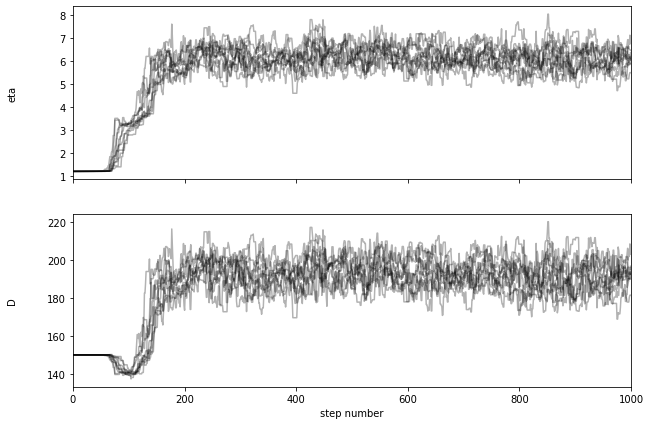

In [31]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


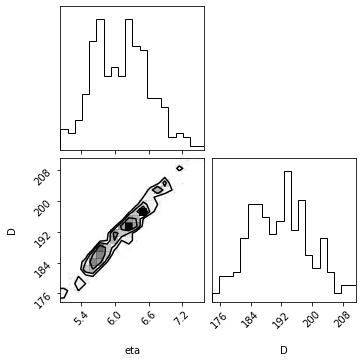

In [32]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

## Truth 0.214

In [33]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.132303939958223


In [34]:
import pandas as pd
rawdata = pd.read_csv(f'time_{name}.txt')
timelist = rawdata['mjd'].tolist()

len(timelist)
timelist

[55328.110949,
 55328.243253,
 55328.375558,
 55328.441646,
 55328.507862,
 55328.57395,
 55328.640166,
 55328.706254,
 55328.838558,
 55364.594842,
 55364.661057,
 55364.727145,
 55364.793361,
 55364.859449,
 55364.925665,
 55364.991753,
 55365.256361,
 55365.322449,
 55365.587056]

eta_fit =  6.12662221121813 D_fit=  191.75142151381112 pv =  0.132303939958223
loss =  inf


/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1466913067.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return sum(((cal-y)/yerr)**2)/nn
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encount

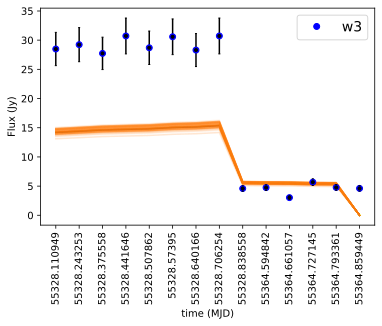

In [35]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_ohhq(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(nt[0:half], yt[0:half],"k")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(nt[0:half], plotmodel[0:half], "C1", alpha=0.1)
plt.plot(nt[0:half],y[0:half],'bo',label = 'w3')
plt.errorbar(nt[0:half], y[0:half], yerr=yerr[0:half], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("time (MJD)")
plt.ylabel("Flux (Jy)");
#ax.xaxis.set_major_locator(plt.MultipleLocator(4))
plt.xticks(nt[0:half],timelist[0:half])
plt.xticks(rotation=90)
plt.savefig(f'{name}_w3.pdf')

/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_3492/1970839062.py:16: Ru

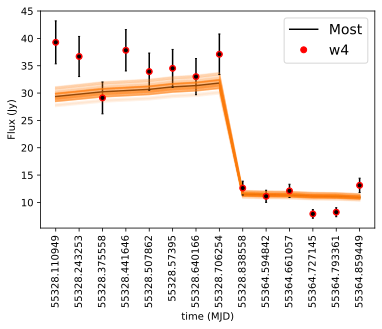

In [36]:
plt.plot(nt[0:half], yt[half:leni],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(nt[0:half], plotmodel[half:leni], "C1", alpha=0.1)
plt.plot(nt[0:half],y[half:leni],'ro',label = 'w4')
plt.errorbar(nt[0:half], y[half:leni], yerr=yerr[half:leni], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("time (MJD)")
plt.ylabel("Flux (Jy)");
#ax.xaxis.set_major_locator(plt.MultipleLocator(4))
plt.xticks(nt[0:half],timelist[0:half])
plt.xticks(rotation=90)
plt.savefig(f'{name}_w4.pdf')
